**DISCLAIMER:**


*   To test the code, it is necessary to create a shortcut to the database files in 
the main folder of your Google Drive. 

  Training: https://drive.google.com/file/d/1QH4ouv9wHSwDxti72SW2LbeUWnDQIwHd/view?usp=sharing

  Train_target: https://drive.google.com/file/d/1YttZCtJjHLCdN7J-SF6-bBY3B3sUr_Xm/view?usp=sharing

  Validation: https://drive.google.com/file/d/1poYj5ilz9jqpuy20_CvGKpew_yKgxEpg/view?usp=sharing

  Validation_target: https://drive.google.com/file/d/1GiaekuFzNrmBdB_9Br4-q1xl3vinCvcR/view?usp=sharing

* 25 GB of RAM are needed to run the notebook on Colab.  

* It is necessary to create a shortcut to the weights of the best model we have got: https://drive.google.com/file/d/1-IIicydyBjRjHAhBiLAy6TlYQ810H6wm/view?usp=sharing

* The dataset downloaded from Kaggle should be uploaded on Google Drive in the main folder with the name 'MaskDataset'




## **Installing and importing the dependecies**

In [ ]:
!pip uninstall -y imgaug
!pip install imgaug
!pip install efficientnet

In [ ]:
%%capture
import os
import multiprocessing as mp
import gc
import numpy as np
np.random.seed(1234)
import pandas as pd
import cv2
from PIL import Image
import imgaug as ia
ia.seed(1234)
import imgaug.augmenters as iaa
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.utils import shuffle as sklearn_shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf
from matplotlib import pyplot
from matplotlib.patches import Rectangle

#from keras_vggface.vggface import VGGFace
from efficientnet.tfkeras import EfficientNetB5
#from tensorflow.keras.applications import MobileNetV2
#from tensorflow.keras.applications import InceptionResNetV2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
PATH_TO_WEIGHTS = '/content/drive/My Drive/Keras3/classification_experiments/CNN_Nov21_17-28-55/ckpts/cp_01.ckpt'

## **Data Loading & Preprocessing**

In [ ]:
dataset_dir = os.path.join('/content/drive/My Drive', 'MaskDataset')
training_dir = os.path.join(dataset_dir, 'training')
validation_dir = os.path.join(dataset_dir, 'validation')
test_dir = os.path.join(dataset_dir, 'test/')
classes = ['0',       # NoMask
           '1',       # AllMask
           '2']       # SomeMask
n_classes = len(classes)
SEED=1234

In [ ]:
X = np.load('/content/drive/My Drive/training.npy',allow_pickle = True)
X_val = np.load('/content/drive/My Drive/validation.npy',allow_pickle = True)
y = np.load('/content/drive/My Drive/train_target.npy',allow_pickle = True)
y_val = np.load('/content/drive/My Drive/validation_target.npy',allow_pickle = True)

For B0 to B7 base models the input shapes are different. We use only B4 and B5, whose expected input shapes are, respectively, 380x380 and 456x456.

In [ ]:
if tf.keras.backend.image_data_format() == 'channels_first':
    input_shape = (3, 456, 456) 
else:
    input_shape = (456, 456, 3)

In [ ]:
def preprocess_input(images, input_shape, crop_padding=0):
    resized = []
    
    if tf.keras.backend.image_data_format() == 'channels_first':
        image_size = input_shape[-1]
    else:    
        image_size = input_shape[0]
    
    for img in images:
        
        h, w = img.shape[:2]
        
        # We crop the image, leaving a centered square of size as the minimun dimension of the initial image
        
        padded_center_crop_size = int((image_size / \
                                  (image_size + crop_padding)) * min(h, w))
        offset_height = ((h - padded_center_crop_size) + 1) // 2
        offset_width = ((w - padded_center_crop_size) + 1) // 2
        image_crop = img[
                        offset_height: padded_center_crop_size + offset_height,
                        offset_width: padded_center_crop_size + offset_width
                    ]

        # We then resize it to the desidered shape (input_shape)
        
        img = cv2.resize(image_crop,
             (input_shape[0], input_shape[1]))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        resized.append(img)
    return resized


X = preprocess_input(X, input_shape)
X_val = preprocess_input(X_val, input_shape)

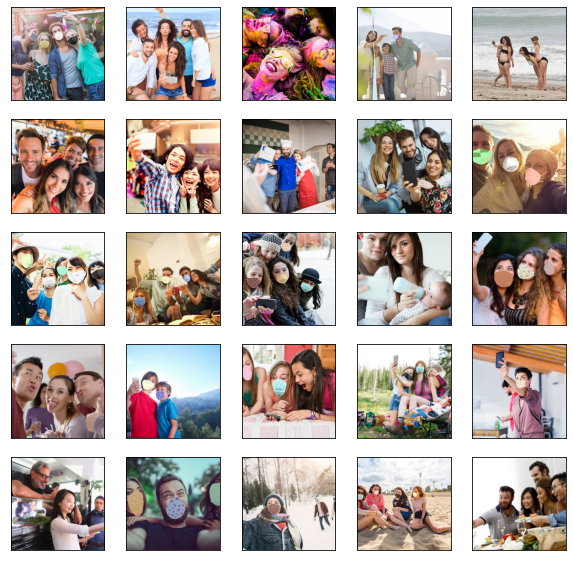

In [ ]:
fig = plt.figure(figsize=(10,10))

for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    idx = np.random.randint(0, len(X))
    plt.imshow(X[idx])

plt.show()

In [ ]:
def normalize_input(img):
    
    img = img.astype('float32')
    
    #Normalize by mean and std deviation
    #img = (img - img.mean()) / (img.std())

    #Normalize by scaling values in [-1,+1]
    img /= 255

    #img -= 1.

    if tf.keras.backend.image_data_format() == 'channels_first':
        img = np.rollaxis(img, 2, 0)
        
    return img
class DataGenerator(tf.keras.utils.Sequence):
    
    def __init__(self,
                 images,
                 labels,
                 num_classes,
                 batch_size,
                 input_shape,
                 shuffle=False,
                 augment=[],
                 n_augmentations=1):
        
        self.input_shape = input_shape
            
        self.original_images = images
        self.original_labels = labels
        self.num_classes = num_classes
        
        self.batch_size = batch_size
        
        self.shuffle = shuffle
        self.augment = augment
        
        self.epoch = 0
        
        self.images = np.array(self.original_images)
        self.labels = np.array(self.original_labels)
        
        augmenters = []
        
        if 'fliplr' in self.augment:
            augmenters.append(iaa.Fliplr(.4))
            
        if 'crop' in self.augment:
            augmenters.append(iaa.Sometimes(0.4,
                                  iaa.CropAndPad(percent=(-0.15, -0.05),
                                                 pad_mode=ia.ALL,
                                                 pad_cval=(0, 255))))
        
        if 'blur' in self.augment:
            augmenters.append(iaa.GaussianBlur((0, 1.5)))
            
        if 'rotate' in self.augment:
            augmenters.append(iaa.Affine(rotate=(-10, 10)))
            
        self.seq = None
        self.n_augmentations = n_augmentations
        if len(augmenters) > 0 and self.n_augmentations > 0:
            self.seq = iaa.Sequential(augmenters, random_order=True)
            for _ in range(self.n_augmentations):
                self.images = np.append(self.images, self.original_images)\
                                .reshape(-1, *self.input_shape)
                self.labels = np.append(self.labels, self.original_labels)\
                                .reshape(-1, self.num_classes)
            
        self.on_epoch_end()
        
    def on_epoch_end(self):
        
        self.epoch += 1
        if self.shuffle == True:
            seed = self.batch_size * self.epoch
                        
            self.images, self.labels = sklearn_shuffle(self.images,
                                                       self.labels,
                                                       random_state=seed)
            
        self.n = self.__len__()
        gc.collect()
    def __len__(self):
        return int(np.floor(self.images.shape[0] / self.batch_size)) 
        
    def __getitem__(self, step):
        current_images = self.images[step * self.batch_size : \
                              (step + 1) * self.batch_size]
        current_labels = self.labels[step * self.batch_size : \
                                    (step + 1) * self.batch_size]
        X, y = self.__generate_batch(current_images, current_labels, step)
        
        return X, y
    
    def __generate_batch(self, images, labels, step):
        X = np.zeros((self.batch_size, *self.input_shape))
        y = np.zeros((self.batch_size, self.num_classes))
        if self.seq is not None:
            if step >= self.n//self.n_augmentations:
                seq_det = self.seq.to_deterministic()
                images = seq_det.augment_images(images=images)
        for idx, img in enumerate(images):
            img = normalize_input(img)
            X[idx] = img
            y[idx] = labels[idx]
            
        return X, y

## **Creating Generators**

In [ ]:
batch_size = 4
all_aug = ['fliplr',
           'crop',
           'blur',
           'rotate']
augment = all_aug
shuffle = True
onehot_y = tf.keras.utils.to_categorical(y)
onehot_y_val = tf.keras.utils.to_categorical(y_val)

In [ ]:
train_generator = DataGenerator(X,
                                onehot_y,
                                num_classes=n_classes,
                                batch_size=batch_size,
                                input_shape=input_shape,
                                augment=augment,
                                shuffle=shuffle)

In [ ]:
validation_generator = DataGenerator(X_val,
                                     onehot_y_val,
                                     num_classes=n_classes,
                                     batch_size=batch_size,
                                     input_shape=input_shape)

## **Model**

In [ ]:
learning_rate =1.3e-4
min_lr = 1e-6
dropout = .3
fc_size=300
freeze=0

base = EfficientNetB5(weights='noisy-student',
                      include_top=False,
                      input_shape=input_shape)

if freeze is None:
  freeze = len(base.layers)
        
for layer in base.layers[:freeze]:
  layer.trainable = False

out = base.output

out = tf.keras.layers.Dropout(dropout,name='top_dropout')(out)

out = tf.keras.layers.Dense(n_classes,
                            name='probabilities')(out)
out = tf.keras.layers.Activation('softmax',
                                  name='softmax',
                                  dtype='float32')(out)

model = tf.keras.models.Model(inputs=base.input, outputs=out)
model._name = base._name

model.load_weights(PATH_TO_WEIGHTS)

model.compile(loss='categorical_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(lr=learning_rate),
                  metrics=['accuracy'])
model.summary()

Model: "efficientnet-b5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 456, 456, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 228, 228, 48) 1296        input_5[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 228, 228, 48) 192         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 228, 228, 48) 0           stem_bn[0][0]                    
____________________________________________________________________________________

In [ ]:
import os
from datetime import datetime

cwd = os.getcwd()
exps_dir = os.path.join('/content/drive/My Drive/Keras3/', 'classification_experiments')
if not os.path.exists(exps_dir):
    os.makedirs(exps_dir)
now = datetime.now().strftime('%b%d_%H-%M-%S')
model_name = 'CNN'
exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
if not os.path.exists(exp_dir):
    os.makedirs(exp_dir)
    
callbacks = []
# Model checkpoint
# ----------------
ckpt_dir = os.path.join(exp_dir, 'ckpts')
if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)
ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp_{epoch:02d}.ckpt'), 
                                                   save_weights_only=True,save_best_only=True)  # False to save the model directly
callbacks.append(ckpt_callback)
# Visualize Learning on Tensorboard
# ---------------------------------
tb_dir = os.path.join(exp_dir, 'tb_logs')
if not os.path.exists(tb_dir):
    os.makedirs(tb_dir)
    
# By default shows losses and metrics for both training and validation
tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir,
                                             profile_batch=0,
                                             histogram_freq=1)  # if 1 shows weights histograms
callbacks.append(tb_callback)
# Early Stopping
# --------------
early_stop = True
if early_stop:
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              mode='min', 
                                              patience=7,
                                              verbose=1)
    callbacks.append(es_callback)

# ReduceLROnPlateau
# --------------
lr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                 mode="min",
                                                 min_lr=0.00001,
                                                 factor=.5,
                                                 patience=2,
                                                 verbose=1)
callbacks.append(lr_callback)

## **Training**

In [ ]:
%%capture
training_enqueuer = tf.keras.utils.OrderedEnqueuer(train_generator,
                                                   use_multiprocessing=True,
                                                   shuffle=False)
training_enqueuer.start(workers=mp.cpu_count())
next(training_enqueuer.get())

In [ ]:
model.fit(train_generator,
          steps_per_epoch=train_generator.n,
          epochs=40,
          validation_data=validation_generator,
          validation_steps=validation_generator.n,
          verbose=1,
          callbacks=callbacks,
          use_multiprocessing=True,
          max_queue_size=2* mp.cpu_count(),
          workers=mp.cpu_count())

## **Sliding Window & Prediction**

In [ ]:
test_dir = os.path.join(dataset_dir, 'test/')

X_test = [cv2.imread(test_dir + img) for img in os.listdir(test_dir)]

We introduce two more types of preprocessing for the test images: instead of doing a centered cropping, we use a sliding window that starts from the left side of the image up to the center (preprocess_left) for 5 times and another one that starts from the right side up to the center (preprocess_right) for another 5 times. Then for the central one we use the standard preprocess_input. 

In [ ]:
def preprocess_left(images, input_shape, slide, crop_padding=16 ):    #slide can be 0,1,2,3,4
    resized = []
    
    if tf.keras.backend.image_data_format() == 'channels_first':
        image_size = input_shape[-1]
    else:    
        image_size = input_shape[0]
    
    for img in images:
        
        h, w = img.shape[:2]
        padded_center_crop_size = int((image_size / \
                                  (image_size + crop_padding)) * min(h, w))
        offset_height = ((h - padded_center_crop_size) + 1) // 2
        offset_width = ((w - padded_center_crop_size) + 1) // 2
        if h < w:
          image_crop = img[offset_height: padded_center_crop_size + offset_height,
                          int(slide*offset_width/7): int(slide*offset_width/7)+ padded_center_crop_size]
        else:
          image_crop = img[int(slide*offset_height/7):int(slide*offset_height/7)+ padded_center_crop_size ,
                           offset_width: padded_center_crop_size + offset_width]
        img = cv2.resize(image_crop,
              (input_shape[0], input_shape[1]))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        resized.append(img)
    return resized

In [ ]:
def preprocess_right(images, input_shape, slide, crop_padding=16):  #slide can be 0,1,2,3,4
    resized = []
    
    if tf.keras.backend.image_data_format() == 'channels_first':
        image_size = input_shape[-1]
    else:    
        image_size = input_shape[0]
    
    for img in images:
        
        h, w = img.shape[:2]
        padded_center_crop_size = int((image_size / \
                                  (image_size + crop_padding)) * min(h, w))
        offset_height = ((h - padded_center_crop_size) + 1) // 2
        offset_width = ((w - padded_center_crop_size) + 1) // 2
        if h < w:
          image_crop = img[offset_height: padded_center_crop_size + offset_height,
                          w-padded_center_crop_size-int(slide*offset_width/7):w-int(slide*offset_width/7)]
        else:
          image_crop = img[h-padded_center_crop_size-int(slide*offset_height/7):h-int(slide*offset_height/7) ,
                           offset_width: padded_center_crop_size + offset_width]
        img = cv2.resize(image_crop,
              (input_shape[0], input_shape[1]))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        resized.append(img)
    return resized

In [ ]:
X_test_left = []
X_test_right = []
y_test_left=[]
y_test_right=[]
for i in range(5):

  X_test_left.append(preprocess_left(X_test, input_shape, i))
  y_test_left.append(np.zeros(len(X_test_left[i])))

  X_test_right.append(preprocess_right(X_test, input_shape, i))
  y_test_right.append(np.zeros(len(X_test_right[i])))

X_test_cen = preprocess_input(X_test, input_shape)
y_test_cen = np.zeros(len(X_test))


In [ ]:
class TestGenerator(tf.keras.utils.Sequence):
    
    def __init__(self,
                 images,
                 labels,
                 num_classes,
                 batch_size,
                 input_shape):
        
        self.input_shape = input_shape
            
        self.original_images = images
        self.original_labels = labels

        self.num_classes = num_classes
        
        self.batch_size = batch_size
        
        self.epoch = 0
            
        self.on_epoch_end()
        
    def on_epoch_end(self):
        self.images = np.array(self.original_images)
        self.labels = np.array(self.original_labels)
        self.n = self.__len__()
        self.epoch += 1

    def __len__(self):
        return int(np.ceil(self.images.shape[0] / self.batch_size))
        
    def __getitem__(self, step):
        current_images = self.images[step * self.batch_size : \
                               (step + 1) * self.batch_size]

        current_labels = self.labels[step * self.batch_size : \
                                     (step + 1) * self.batch_size]

        X, y = self.__generate_batch(current_images, current_labels)
        return X, y
    
    def __generate_batch(self, images, labels):
        X = np.zeros((self.batch_size, *self.input_shape))
        y = np.zeros((self.batch_size, self.num_classes))

        for idx, img in enumerate(images):
            img = normalize_input(img)
            X[idx] = img
            y[idx] = labels[idx]
            
        return X, y

Here we compute the 5 predictions for the left side.

In [ ]:
test_generator_left=[]
predictions_left=[]
for i in range(5):
  test_generator_left.append(TestGenerator(X_test_left[i],
                                  tf.keras.utils.to_categorical(y_test_left[i]),
                                  num_classes=n_classes,
                                  batch_size=1,
                                  input_shape=input_shape))

  predictions_left.append(model.predict_generator(test_generator_left[i],
                                      verbose=1,
                                      use_multiprocessing=True,
                                      workers=mp.cpu_count()))

  predictions_left[i] = np.argmax(predictions_left[i], axis=1)

450/450 [==============================] - 15s 34ms/step


Here we compute the prediction for the center of the image.

In [ ]:
test_generator_cen = TestGenerator(X_test_cen,
                                  tf.keras.utils.to_categorical(y_test_cen),
                                  num_classes=n_classes,
                                  batch_size=1,
                                  input_shape=input_shape)

predictions_cen = model.predict_generator(test_generator_cen,
                                      verbose=1,
                                      use_multiprocessing=True,
                                      workers=mp.cpu_count())

predictions_cen = np.argmax(predictions_cen, axis=1)

450/450 [==============================] - 15s 34ms/step


Here we compute the 5 predictions for the right side.

In [ ]:
test_generator_right=[]
predictions_right=[]
for i in range(5):
  test_generator_right.append(TestGenerator(X_test_right[i],
                                  tf.keras.utils.to_categorical(y_test_right[i]),
                                  num_classes=n_classes,
                                  batch_size=1,
                                  input_shape=input_shape))

  predictions_right.append(model.predict_generator(test_generator_right[i],
                                      verbose=1,
                                      use_multiprocessing=True,
                                      workers=mp.cpu_count()))

  predictions_right[i] = np.argmax(predictions_right[i], axis=1)

450/450 [==============================] - 15s 34ms/step


We weight each prediction and the final prediction is given by the class that has the highest score.

In [ ]:
prediction = []
weight = {"0":5,"1":5,"2":5,"3":5,"4":5}

for i in range(len(X_test_cen)):
  s = np.array([0, 0, 0])
  for j in range(5):
    if predictions_left[j][i]==0: s[0]+=weight[str(j)]
    if predictions_left[j][i]==1: s[1]+=weight[str(j)]
    if predictions_left[j][i]==2: s[2]+=weight[str(j)]

    if predictions_right[j][i]==0: s[0]+=weight[str(j)]
    if predictions_right[j][i]==1: s[1]+=weight[str(j)]
    if predictions_right[j][i]==2: s[2]+=weight[str(j)]

  if predictions_cen[i]==0: s[0]+=4
  if predictions_cen[i]==1: s[1]+=4
  if predictions_cen[i]==2: s[2]+=4
  pred = np.argmax(s)
  prediction.append(pred)

In [ ]:
def create_csv(results, results_dir='/content/drive/My Drive', csv_fname='submission.csv'):
    
    with open(os.path.join(results_dir, csv_fname), 'w') as f:

        f.write('Id,Category\n')

        for key, value in results.items():
            f.write(key + ',' + str(value) + '\n')
            
image_filenames = next(os.walk(test_dir))[2]

results = {}
for idx, image_name in enumerate(image_filenames):
    results[image_name] = prediction[idx]

csv_fname = 'effnetb5-submission-slide.csv'           
create_csv(results, csv_fname=csv_fname)